In [70]:
# all of these libraries are used for plotting
import numpy as np
import matplotlib.pyplot as plt


# Define the grid on which we will evaluate our classifier
# it ranges from -2 to 3 in x, -5 to 3 in y
x_min, x_max = -1, 2.8
y_min, y_max = -4, 2.8
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

# Our grid is currently a numpy array. We transform it into a torch Variable
# This will allow us to call Forward on it.
to_forward = np.array(zip(xx.ravel(), yy.ravel()))

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')
    plt.axis([x_min, x_max, y_min, y_max])

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)
        

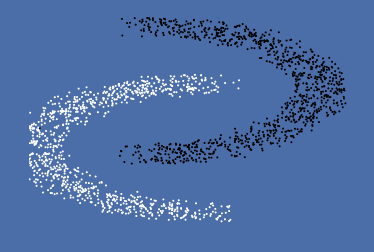

In [71]:
%matplotlib inline
# load the data and visualize it
data = np.load('./double_moon.npz')
X = data['X']
Y = data['Y']
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [72]:
class Sequential(object):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # -(label * log(output) + (1-label) * log(1-output))
        self.loss = - (label * np.log(out) + (1-label) * np.log(1-out))
        if label == 0:
            self.loss_grad =  (1-label) / (1-out + 1e-10)
        else:
            self.loss_grad = - label / (out + 1e-10)
        
        return self.loss

    def backward(self):
        current_grad = self.loss_grad
        for layer in reversed(self.layers):
            current_grad = layer.backward(current_grad)
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.A = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)

    def forward(self, x):
        self.saved_for_backward = x.copy()
        return np.dot(x, self.A) + self.b

    def backward(self, grad_output):
        # y_i = \sum_j A_{i,j} x_j + b_i
        # d y_i / d A_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d A_{i,j} = x_j * grad_output[i]  (by the chain rule)
        self.grad_A = np.outer(self.saved_for_backward, grad_output)

        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        self.grad_b = grad_output.copy()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = A_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        return np.dot(self.A, grad_output).squeeze()
    
    def step(self, learning_rate):
        # we just move in the opposite direction given by the gradient for a distance "learning_rate"
        self.A -= learning_rate * self.grad_A
        self.b -= learning_rate * self.grad_b
    
    
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.save_for_backward = (x > 0).astype('float')
        return self.save_for_backward * x
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        self.grad = self.save_for_backward * grad_output
        return self.grad.squeeze()
    
    def step(self, learning_rate):
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.save_for_backward = np.exp(-x)
        return 1. / (1 + self.save_for_backward)
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2    (you can use wolframalpha for this)
        self.grad = (grad_output * self.save_for_backward) / (self.save_for_backward + 1) ** 2
        return self.grad.squeeze()
    
    def step(self, learning_rate):
        pass

<IPython.core.display.Javascript object>


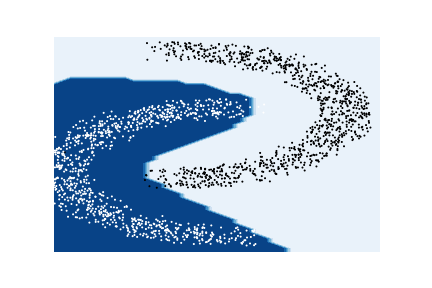

In [ ]:
%matplotlib notebook
h=50

# define your network with nn.sequential
# it could be a linear layer with 2 inputs and h outputs, followed by a ReLU
# then a linear layer with h inputs and 1 outputs, followed by a sigmoid
# feel free to try other architectures
net = Sequential([
    MyLinear(2, h),
    MyReLU(),
    MyLinear(h, 1),
    MySigmoid()
])

fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
losses = []
for it in xrange(10000):
    # pick a random example id 
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X[j:j+1]
    label = Y[j]

    # do a forward pass on the example
    output = net.forward(example)

    # compute the loss according to your output and the label
    loss = net.compute_loss(output, label)
    losses.append(loss.squeeze())
    # backward pass
    net.backward()

    # gradient step
    net.step(1e-2)

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, net)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, net)
fig.canvas.draw()